In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plt2
import igraph as ig
import networkx as nx
import itertools
import math
import random
from scipy.stats import kde
from networkx.algorithms import bipartite
from sklearn import preprocessing
from sklearn.preprocessing import normalize, MinMaxScaler

In [2]:
#generating Barabasi network

g = ig.Graph.Barabasi(1000, 3)

In [3]:
#setting nodes' labels

g.vs['label'] = [i for i in range(g.vcount())]

In [4]:
#creating array with [(label1, degree node1), (label2, degree node2)...]

labels_deg = [(g.vs['label'][i], float(g.degree(i))) for i in range(g.vcount())]

In [5]:
#sorting in descendent order

labels_deg.sort(key=lambda x: x[1], reverse=True)

In [6]:
#calculating the robustness

def robustness_stats_node_component(g, stat_array):
	# Make a copy of the network
	g_copy = g.copy()

	N = g_copy.vcount()

	number_removed = np.zeros(N+1)
    
	for i in range(g.vcount()):
		number_removed[i] = i / float(N)
        
	number_removed[N] = 1.0


	P_infty = np.zeros(N+1)

	# Find larger component
	cl = g_copy.components()
	P_infty_baseline = float(max(cl.sizes()))

	P_infty[0] = 1.0

	count = 1
	while(g_copy.vcount() > 0 and count < len(stat_array)):
		index = g_copy.vs.find(label=stat_array[count-1][0]).index

		g_copy.delete_vertices(index)

		cl = g_copy.components()

		if(len(cl) > 0):
			P_infty[count] += float(max(cl.sizes())) / P_infty_baseline 
		else:
			P_infty[count] += 0.0

		count = count + 1

	if(count < g.vcount()):
		number_removed = number_removed[0:count]
		P_infty = P_infty[0:count]

	return number_removed,P_infty

In [7]:
#calculating the robustness

def robustness_failure_node(g, simulations=50):
	N = g.vcount()

	number_removed = np.zeros(N+1)
    
	for i in range(g.vcount()):
		number_removed[i] = i / float(N)
	number_removed[N] = 1.0

	P_infty = np.zeros(N+1)

	# Find larger component
	cl = g.components()
	P_infty_baseline = float(max(cl.sizes()))

	for _ in range(simulations):
		g_copy = g.copy()
		P_infty[0] += 1.0

		count = 1
		while(g_copy.vcount() > 0):
			index = int(np.random.random() * g_copy.vcount())
			g_copy.delete_vertices(index)

			cl = g_copy.components()
			if(len(cl) > 0):
				P_infty[count] += float(max(cl.sizes())) / P_infty_baseline 
			else:
				P_infty[count] += 0.0

			count = count + 1

	# Compute the average
	P_infty = P_infty / float(simulations)

	return number_removed,P_infty

In [9]:
number_removed_comp, P_infinity_comp = robustness_stats_node_component(g, labels_deg)
number_removed_random, P_infinity_random = robustness_failure_node(g, 100)

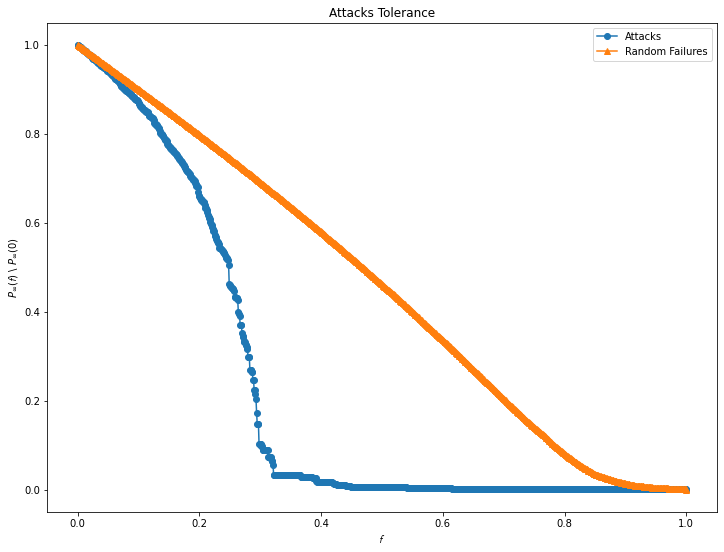

In [10]:
plt.figure(figsize=(12,9)) 

plt.plot(number_removed_comp, P_infinity_comp, marker='o', label='Attacks')
plt.plot(number_removed_random, P_infinity_random, marker='^', label='Random Failures')
plt.title('Attacks Tolerance')
plt.xlabel('$\mathcal{f}$')
plt.ylabel('$P_\infty (\mathcal{f})$ \ $P_\infty (0)$')
plt.legend()
plt.savefig('Attacks_tolerance.pdf', dpi=600)

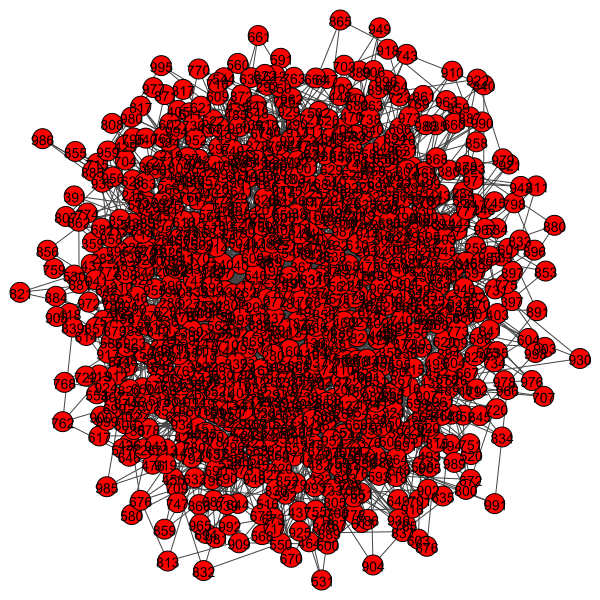

In [11]:
ig.plot(g)